In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import xgboost as xgb
from interpret import show
from interpret.blackbox import ShapKernel, PartialDependence



### Data Prep

In [3]:
data = pd.read_csv("./DATA/pakistanCleanOneHot.csv")

In [4]:
data.set_index('eventid', inplace=True)

In [5]:
data.columns

Index(['city', 'latitude', 'longitude', 'location', 'summary', 'multiple',
       'success', 'suicide', 'attacktype1', 'targtype1',
       ...
       'targtype1_txt_Other', 'targtype1_txt_Maritime',
       'weaptype1_txt_Explosives', 'weaptype1_txt_Firearms',
       'weaptype1_txt_Unknown', 'weaptype1_txt_Melee',
       'weaptype1_txt_Incendiary', 'weaptype1_txt_Chemical',
       'weaptype1_txt_Other',
       'weaptype1_txt_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)'],
      dtype='object', length=135)

Removing columns that have too many categories or too much text data, or won't be in our test data.

In [6]:
exclude_cols = ['city','location','summary','attacktype1','targtype1','targsubtype1','targsubtype1_txt', 'corp1', 'target1', 'gname', 'claimed', 'claimmode',
       'claimmode_txt','weaptype1','weapsubtype1','weapsubtype1_txt']
for col in exclude_cols:
    del data[col]

In [7]:
data.head()

,latitude,longitude,multiple,success,suicide,nkill,nkillus,nkillter,nwound,nwoundus,...,targtype1_txt_Other,targtype1_txt_Maritime,weaptype1_txt_Explosives,weaptype1_txt_Firearms,weaptype1_txt_Unknown,weaptype1_txt_Melee,weaptype1_txt_Incendiary,weaptype1_txt_Chemical,weaptype1_txt_Other,"weaptype1_txt_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)"
eventid,,,,,,,,,,,,,,,,,,,,,
200712030005,30.803630,66.711752,0,1,0,6.0,0.0,0.0,5.0,0.0,...,0,0,1,0,0,0,0,0,0,0
200712040005,34.006004,71.537430,0,1,1,1.0,0.0,1.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
200712060008,29.034412,69.158661,0,1,0,1.0,0.0,0.0,4.0,0.0,...,0,0,1,0,0,0,0,0,0,0
200712080003,27.809921,66.620956,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
200712090002,28.458421,68.133223,0,1,0,4.0,0.0,0.0,1.0,0.0,...,0,0,0,1,0,0,0,0,0,0


Creating train and test data

In [8]:
train_data = data[(data['TTP']==0) | (data['TTP'] ==1)].copy()
test_data = data[pd.isna(data['TTP'])].copy()
del test_data['TTP']

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


In [9]:
train_data.fillna(0, inplace=True)
test_data.fillna(0, inplace=True)

In [10]:
ycol = 'TTP'
X_data = train_data[[col for col in train_data.columns if col != 'TTP']]
y_data = train_data[ycol]

In [11]:
## Training/test creation
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.25, random_state=35)

### Model

In [12]:
model = xgb.XGBRegressor(objective='binary:logistic', max_depth=10, eta=.5)
model.fit(X_train, y_train)

[19:38:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.5, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.5, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

### Generate predictions and evaluate

In [13]:
y_preds = model.predict(X_test)

In [14]:
preds_bin = [int(i>0.5) for i in y_preds]
print(f"Accuracy: {accuracy_score(y_test, preds_bin)}")

Accuracy: 0.8266494178525227


In [15]:
print(f"Predict 0 accuracy: {accuracy_score(y_test, [0 for _ in range(len(y_preds))])}")

Predict 0 accuracy: 0.553686934023286


### Explain model

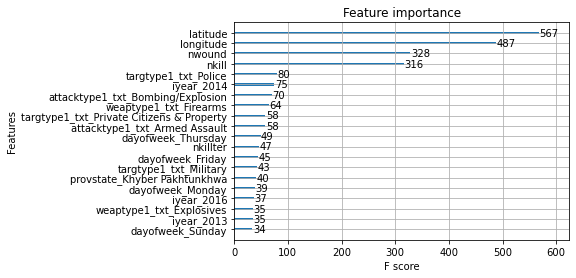

In [16]:
from xgboost import plot_importance
from matplotlib import pyplot

# plot feature importance
plot_importance(model, max_num_features=20)
pyplot.show()

In [17]:
shap = ShapKernel(predict_fn=model.predict, data=X_train[:100])

In [18]:
shap_local = shap.explain_local(X_test.head(10), y_test.head(10))

show(shap_local)

  0%|          | 0/10 [00:00<?, ?it/s]num_full_subsets = 1
remaining_weight_vector = [0.12248517 0.08251632 0.06254562 0.05057452 0.04260354 0.03691861
 0.03266271 0.02935974 0.02672404 0.02457383 0.02278794 0.02128249
 0.01999758 0.01888928 0.01792466 0.01707854 0.01633136 0.01566766
 0.0150751  0.01454369 0.01406528 0.01363313 0.01324164 0.01288611
 0.01256258 0.01226768 0.01199855 0.0117527  0.01152802 0.01132265
 0.01113502 0.01096371 0.01080751 0.01066537 0.01053636 0.01041965
 0.01031454 0.0102204  0.0101367  0.01006297 0.00999879 0.00994383
 0.00989779 0.00986044 0.00983159 0.00981108 0.00979881 0.00979473]
num_paired_subset_sizes = 48
weight_left = 0.8040924782682237
np.sum(w_aug) = 98.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.10982088 -0.08919982 -0.01395054 -0.01059723  0.          0.05847551
  0.14731875  0.00924793  0.00495503  0.         -0.00798075 -0.01144286
  0.          0.          0.         -0.02559465  0.          0.02636205
 -0.06021261  0.          0.         

<!-- http://127.0.0.1:7001/2340310754016/ -->

### Shapley Values Intro

Shapley values can help us understand what and how features contributed to our final prediction. The goal is to understand how a model got to the prediction it did. In the above plot we see that the number of terrorists killed, along with a couple location features, pushed our TTP probabibility over 50%. While there were other features that would lead us to believe it was not a TTP attack, they were not enough to bring us below 50%. 

In [19]:
pdp = PartialDependence(predict_fn=model.predict, data=X_train, num_points=50)

In [20]:
pdp_global = pdp.explain_global()

show(pdp_global)

No overall plot to display: -1|ShapKernel_0
Generating mini dash
Generated mini dash


<!-- http://127.0.0.1:7001/2338841010912/ -->

No overall plot to display: -1|ShapKernel_0
No overall plot to display: -1|PartialDependence_0
